In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import glob

In [20]:
# Style for the visualizations
sns.set_palette('Set3')
sns.set_style('whitegrid')

In [21]:
# Merge data into a single file
directory = 'Sales_Data/*'
dfs = [pd.read_csv(filename) for filename in glob.glob(directory)]
df = pd.concat(dfs)
df.to_csv('sales_data.csv', index=False)

In [22]:
# Read new single file
df = pd.read_csv('sales_data.csv')
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [23]:
# Drop N/A rows
df.dropna(inplace=True)

In [24]:
# Remove column names as rows
df = df[df['Order ID'] != 'Order ID']

In [25]:
# Separate last column into columns: 'Address', 'State', 'City'
addresses = np.array([address.split(', ') for address in df['Purchase Address'].values])
df['Street'], df['City'], df['State'] = addresses[:, 0], addresses[:, 1], [x[:2] for x in addresses[:, 2]]
df.drop(['Purchase Address', 'Street'], axis='columns', inplace=True)

In [26]:
# Add total price column
df['Order Price'] = pd.to_numeric(df['Quantity Ordered']) * pd.to_numeric(df['Price Each'])

In [27]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,City,State,Order Price
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,Dallas,TX,23.90
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,Boston,MA,99.99
3,176560,Google Phone,1,600,04/12/19 14:38,Los Angeles,CA,600.00
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,Los Angeles,CA,11.99
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,Los Angeles,CA,11.99


In [28]:
# Add column data types int and float
dtypes = ['object', 'object', 'int', 'float', 'object', 'category', 'category', 'float']
col_types = dict(zip(df.columns, dtypes))
df = df.astype(col_types)

# Add column type datetime and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'])


In [29]:
# Column data types and DataFrame Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186849
Data columns (total 8 columns):
Order ID            185950 non-null object
Product             185950 non-null object
Quantity Ordered    185950 non-null int64
Price Each          185950 non-null float64
Order Date          185950 non-null datetime64[ns]
City                185950 non-null category
State               185950 non-null category
Order Price         185950 non-null float64
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 10.3+ MB


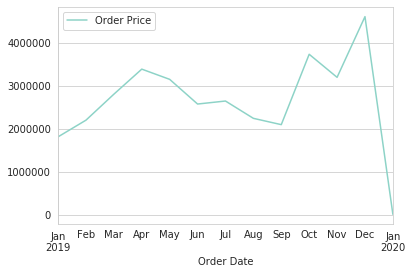

In [30]:
# What was the best month for sales?
sales_per_month = df.set_index('Order Date')
sales_per_month = sales_per_month[['Order Price']].resample('M').sum()
sales_per_month.plot()


# Answer
# December was the best month for sales.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

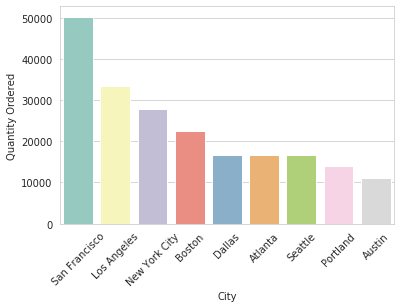

In [31]:
# Which city sold the most products?
city_count = df.groupby('City').sum()
city_count.sort_values('Quantity Ordered', ascending=False, inplace=True)
city_count.reset_index(inplace=True)
sns.barplot(x='City', y='Quantity Ordered', data=city_count, order=city_count['City'])
plt.xticks(rotation=45)

# Answer
# San Francisco sells the most products.

In [32]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,City,State,Order Price
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,Dallas,TX,23.90
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,Boston,MA,99.99
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,Los Angeles,CA,600.00
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,Los Angeles,CA,11.99
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,Los Angeles,CA,11.99


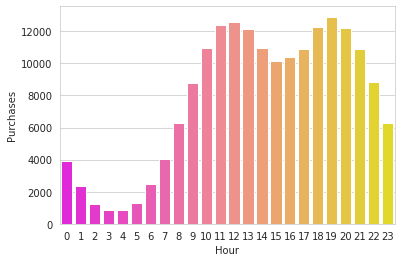

In [33]:
# What time should we display advertisements to maximize the likelihood of purchases?
times = pd.to_datetime(df['Order Date'])
times = pd.DataFrame(times.groupby(times.dt.hour).count())
times.index.name, times.columns = 'Hour', ['Purchases']
sns.barplot(x=times.index, y=times['Purchases'], palette='spring')

# Answer:
# Data suggests most purchases occur at 12:00 and 19:00 hours. 

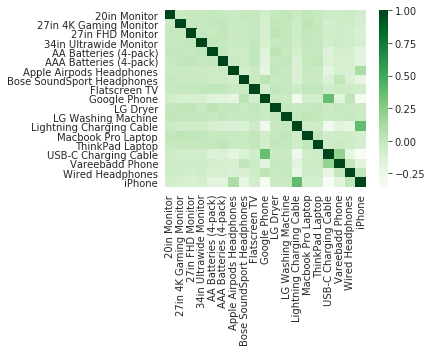

In [41]:
# What products are most often sold together?

sold_together = df[['Order ID', 'Product']]
dummified = pd.get_dummies(sold_together, columns=sold_together.columns[1:], prefix='', prefix_sep='').reset_index(drop=True)
sold_together = dummified.groupby('Order ID').sum()
sold_together = sold_together[sold_together.sum(axis='columns') > 1]

 # Figure configuration
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(sold_together.corr(), cmap='Greens')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()

# Answer
# Google Phone + USB-C Charging Cables & iPhone with Lightning Charging Cable.

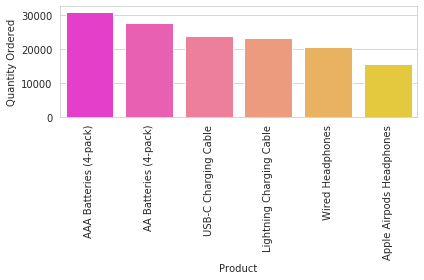

In [70]:
# What product sold the most?

most_sold = df.groupby('Product')[['Quantity Ordered']].sum()
most_sold.sort_values('Quantity Ordered', ascending=False, inplace=True)
most_sold = most_sold.head(6)

sns.barplot(x=most_sold.index, y=most_sold['Quantity Ordered'], palette='spring')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()